In [1]:
import importlib

import os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from ics.hxutils import hxramp
from h4rg_analysis import io, ramputils, statutils, plot
import makefigures_noise

In [2]:
tfilename = './tempcorr'

In [3]:
bestbaselines = open ('../data/paths/best_ever_baseline_darks_8_21_2022.txt', 'r').read().splitlines()[1:]

In [94]:
rampA = hxramp.HxRamp(io.jhu2tiger(bestbaselines[18]))
rampB = hxramp.HxRamp(io.jhu2tiger(bestbaselines[1]))

In [98]:
nbins=4
step = rampA.ncols // nbins
sl_indices = np.concatenate ( [np.arange(0, rampA.ncols, step), [rampA.ncols+1]] )
slices = [ slice(sl_indices[idx], sl_indices[idx+1]) for idx in range(sl_indices.size-1) ]

In [6]:
exptime = rampA.header()['W_FRMTIM'] # sec
gain = 3.2 # e-/ADU, measured by JHU for detector 18660
unit_conversion = gain / exptime # e/ADU / s 

In [84]:
arr = np.load('../data/output/PFJB02401423_data_S0-E-1_utrparam.npy')

In [90]:
nbins = 8
step = rampA.ncols // nbins
sl_indices = np.concatenate ( [np.arange(0, rampA.ncols, step), [rampA.ncols+1]] )
slices = [ slice(sl_indices[idx], sl_indices[idx+1]) for idx in range(sl_indices.size-1) ]

In [18]:
sidx=-2
tfileA=tempfile.NamedTemporaryFile(dir='./')
cubeA,_ = io.corrStack_memmap ( rampA, filename=tfileA, 
                               slicey=slices[sidx], slicex=slices[sidx] )


tfileB=tempfile.NamedTemporaryFile(dir='./')
cubeB,_ = io.corrStack_memmap ( rampB, filename=tfileB, 
                               slicey=slices[sidx], slicex=slices[sidx] )

tfileA=tempfile.NamedTemporaryFile(dir='./')
dataA,_ = io.dataStack_memmap ( rampA, filename=tfileA, 
                               slicey=slices[sidx], slicex=slices[sidx] )


tfileB=tempfile.NamedTemporaryFile(dir='./')
dataB,_ = io.dataStack_memmap ( rampB, filename=tfileB, 
                               slicey=slices[sidx], slicex=slices[sidx] )


In [44]:
read_idx=299
ca = cubeA[:(read_idx+1)] #+ irp0A[slices[0],slices[0]]
cb = cubeB[:(read_idx+1)] #+ irp0B[slices[0],slices[0]]
_,rhatA,rhatA_se = ramputils.utr_expectedflux ( ca )
_,rhatB,rhatB_se = ramputils.utr_expectedflux ( cb )

Median rate: 0.0113 e/s
Expected shot noise: 6 e
Observed total RMS: 12 e
SQRT[RMS^2 - shot^2] = 10 e


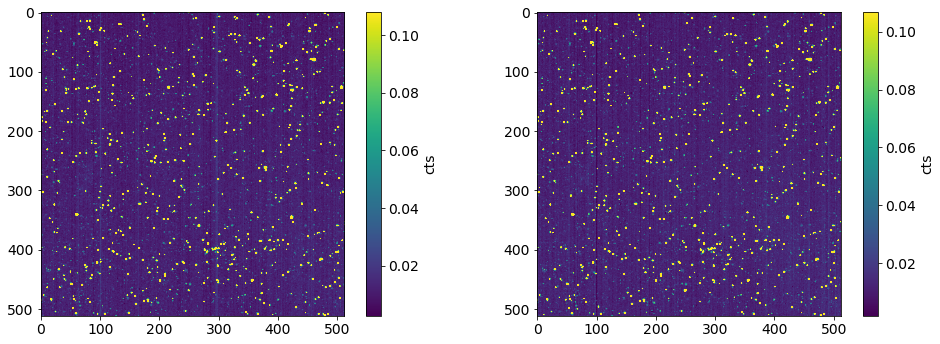

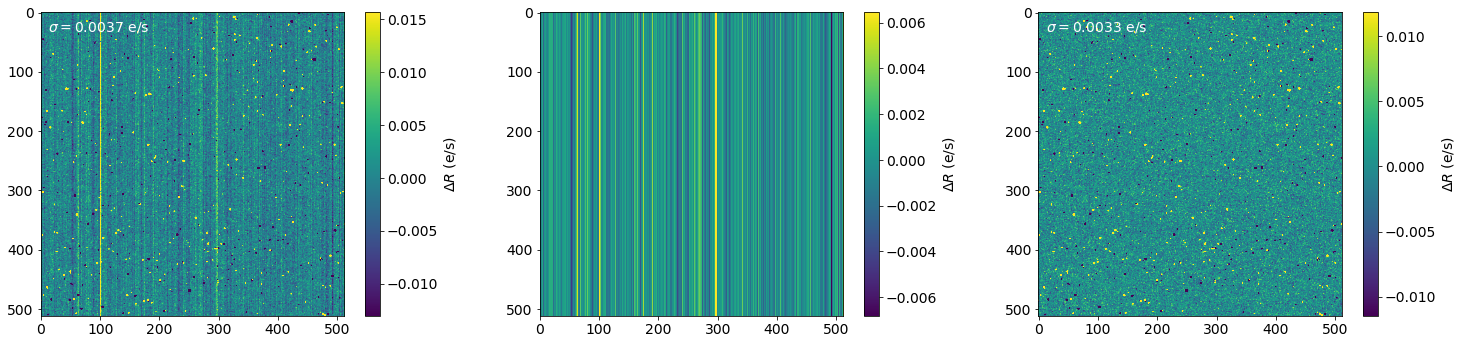

In [45]:
makefigures_noise.show_r2rdiff ( rhatA[0], rhatB[0], exptime, 300, gain)

In [76]:
read_idx=299
ca = dataA[:(read_idx+1)] #+ irp0A[slices[0],slices[0]]
cb = dataB[:(read_idx+1)] #+ irp0B[slices[0],slices[0]]
_,datarateA,rhatA_se = ramputils.utr_expectedflux ( ca )
_,datarateB,rhatB_se = ramputils.utr_expectedflux ( cb )

Median rate: 0.0074 e/s
Expected shot noise: 4 e
Observed total RMS: 50 e
SQRT[RMS^2 - shot^2] = 50 e


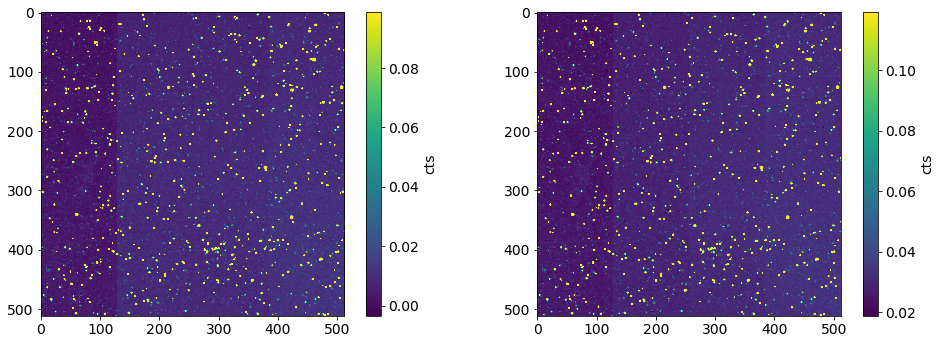

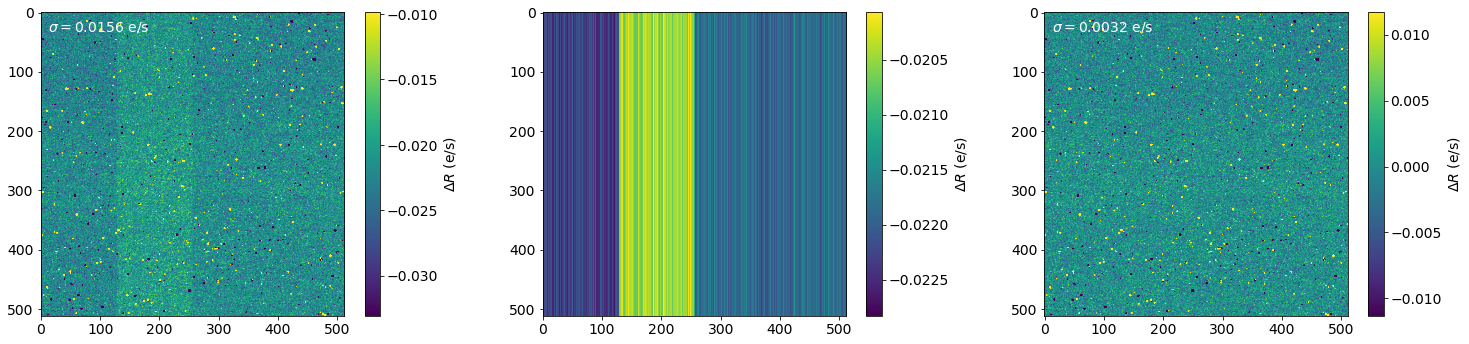

In [77]:
makefigures_noise.show_r2rdiff ( datarateA[0], datarateB[0], exptime, 300, gain)

In [78]:
read_idx=299
ca = (dataA-cubeA)[:(read_idx+1)] #+ irp0A[slices[0],slices[0]]
cb = (dataB-cubeB)[:(read_idx+1)] #+ irp0B[slices[0],slices[0]]
_,irprateA,_ = ramputils.utr_expectedflux ( ca )
_,irprateB,_ = ramputils.utr_expectedflux ( cb )

Median rate: -0.0035 e/s
Expected shot noise: 3 e
Observed total RMS: 50 e
SQRT[RMS^2 - shot^2] = 49 e


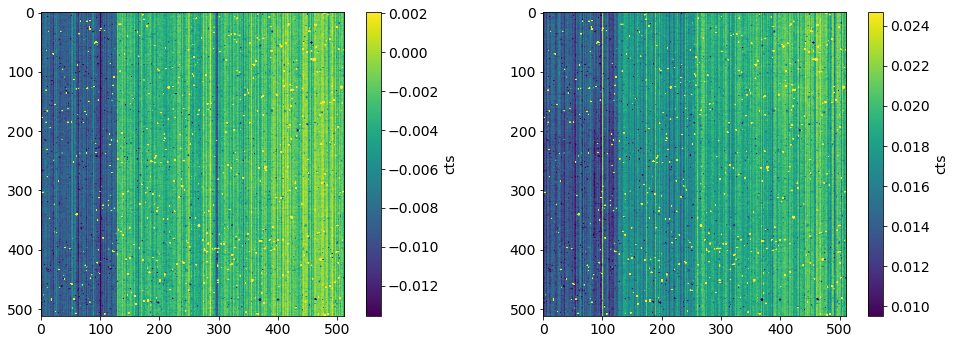

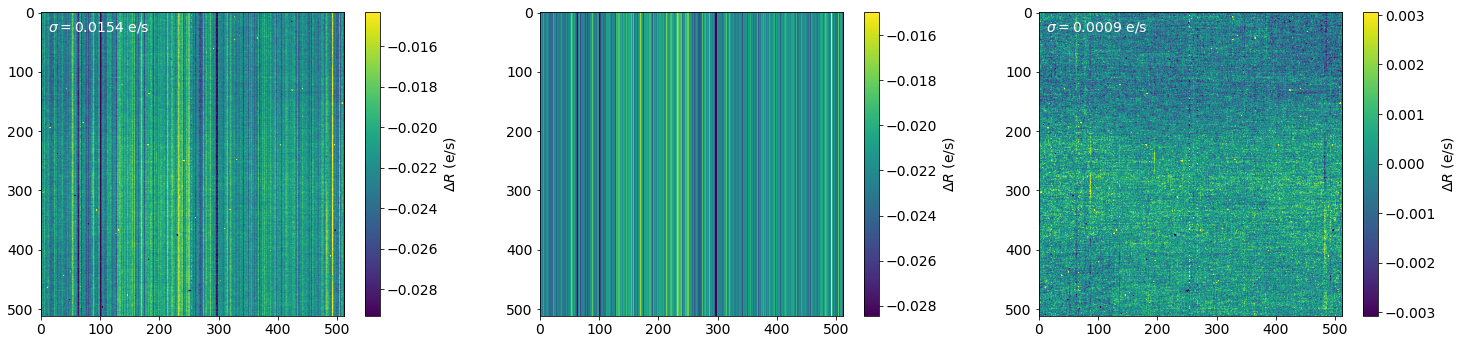

In [81]:
makefigures_noise.show_r2rdiff ( irprateA[0], irprateB[0], exptime, 300, gain)

* look at border pixels
* check to see if data slope variation tracks IRP slope variations
* (preamp reset at beginning of each frame, device only reset at beginning of each ramp)
* how much does the slope vary along the column (OLS along each column of the rate map)
* is ktc noise purely additive? Or is there a multiplicative component?
* (data - IRP) - (data - IRP) removees the same columnated structure as slope fitting, but some columnated structure remains
* taking one frame with columnated structure; median over columns
* write down amplitudes of the ramp differences
* instead of moments use IQR
* ~email~ accost Eddie -- procedure to get his darks

Need to figure out how the noise evolved with time.
e.g. decompose the signal into sqrt(N) (N-2? OLS) component, linear component (dark current). 


In [10]:
%%time
xs, corr_arr = ramputils.compute_uncertainties ( cubeA, cubeB, gain=makefigures_noise.gain,
                                               exptime = rampA.header()['W_FRMTIM'])

/tigress/kadofong/machine_harmony/repos_post0903/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/tigress/kadofong/machine_harmony/repos_post0903/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/tigress/kadofong/machine_harmony/repos_post0903/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tigress/kadofong/machine_harmony/repos_post0903/scipy/stats/stats.py:3218: RuntimeWarning: Mean of empty slice.
  c_mean = c.mean()
/tigress/kadofong/machine_harmony/repos_post0903/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tigress/kadofong/machine_harmony/repos_post0903/h4rg_analysis/ramputils.py:140: RuntimeWarning: invalid value encountered in double_scalars
  rn_arr[1,idx] = np.sqrt ( np.nansum(ediff**2) / (2.*np.isfinite(ed

CPU times: user 15.3 s, sys: 7.19 s, total: 22.5 s
Wall time: 22.6 s


In [17]:
%%time
xs, data_arr = ramputils.compute_uncertainties ( dataA, dataB,
                                                 gain=makefigures_noise.gain,
                                                 exptime = rampA.header()['W_FRMTIM'])

CPU times: user 17.2 s, sys: 7.17 s, total: 24.3 s
Wall time: 24.4 s


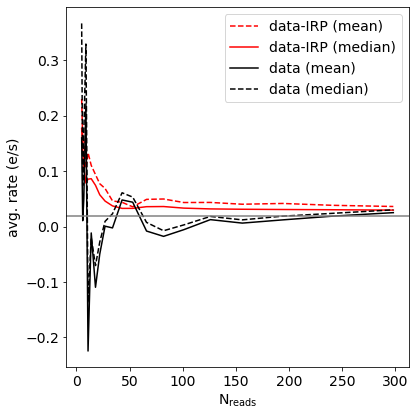

In [68]:
plt.plot ( xs, corr_arr[3], color='r', ls='--', label='data-IRP (mean)')
plt.plot ( xs, corr_arr[4], color='r', label='data-IRP (median)')
plt.plot ( xs, data_arr[4], color='k', label='data (mean)')
plt.plot ( xs, data_arr[3], color='k', ls='--', label='data (median)')
plt.axhline(0.019, color='grey')
plt.xlabel(r'N$_{\rm reads}$')
plt.ylabel(r'avg. rate (e/s)')
plt.tight_layout ()
plt.legend()
plt.savefig('../figures/avgrate.png')

<AxesSubplot:>

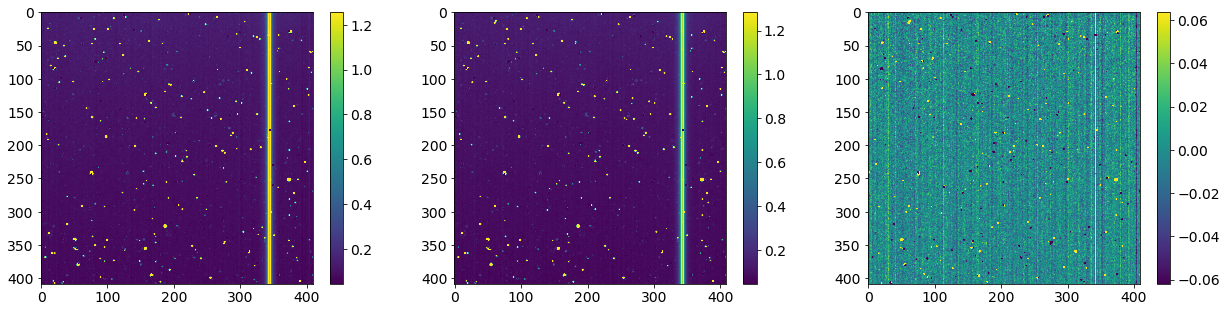

In [8]:
fig, axarr = plt.subplots(1,3,figsize=(21,5))
plot.scaled_imshow(rhatA[0], ax=axarr[0])
plot.scaled_imshow(rhatB[0], ax=axarr[1])
plot.scaled_imshow(rhatB[0]-rhatA[0], ax=axarr[2])

In [9]:
rdiff = rhatB[0] - rhatA[0]

In [10]:
from scipy import stats

In [133]:
findices = np.arange(300).reshape(300,1,1,)
reset = 1005.
#fy = np.ones([1,50,50])*reset #
fy = np.random.normal(1000., 200., [2,50,50])
frate = .13
noise = 50.
fake_cubeA= findices*frate + fy[[0]] + np.random.normal(0., noise, [findices.size, fy.shape[1], fy.shape[2]])
#fake_cubeA[:,:10,:10] += np.random.normal(0., noise, [findices.size, 10,10])
fake_cubeB= findices*frate + fy[[1]] + np.random.normal(0., noise, [findices.size, fy.shape[1], fy.shape[2]])
#fake_cubeB[:,:10,:10] += np.random.normal(0., noise, [findices.size, 10,10])

In [134]:
xs, rn_arr = ramputils.compute_uncertainties ( fake_cubeA, fake_cubeB, expected=frate)

Caution! Gain=1
Caution! Exptime=1 sec


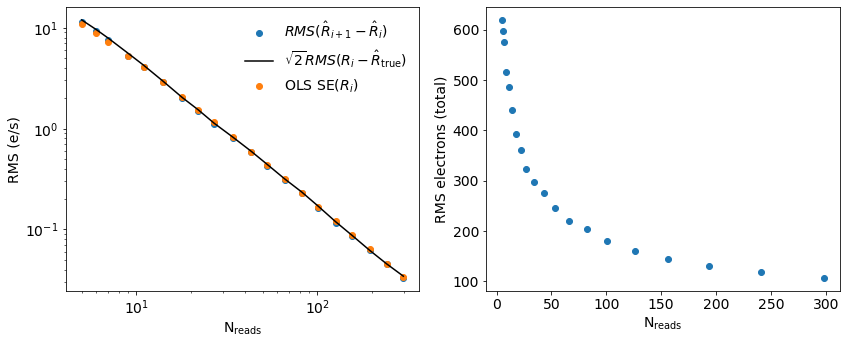

In [397]:
fig, axarr = plt.subplots(1,2,figsize=(12,5))
ax = axarr[0]
ax.scatter ( xs, rn_arr[0], label=r'$RMS(\hat R_{i+1} - \hat R_i)$' )
ax.plot ( xs, rn_arr[1]*np.sqrt(2.), label=r'$\sqrt{2}RMS(R_i - \hat R_{\rm true})$', color='k' )
ax.scatter ( xs, rn_arr[2], label=r'OLS SE($R_i$)' )
ax.legend (frameon=False)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'N$\rm_{reads}$')
ax.set_ylabel('RMS (e/s)')

ax = axarr[1]
ax.scatter ( xs, rn_arr[0]*rampA.header()['W_FRMTIM']*xs )

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'N$\rm_{reads}$')
ax.set_ylabel('RMS electrons (total)')

plt.tight_layout ()
plt.savefig('../figures/perfect_whitenoise.png')

In [416]:
findices = np.arange(300).reshape(300,1,1,)
reset = 1005.
#fy = np.ones([1,50,50])*reset #
fy = np.random.normal(1000., 200., [2,50,50])
frate = .13
noise = 50.
notnoise = .1*noise*np.sin(findices)
rising_cubeA = findices*frate + fy[[0]] + np.random.normal(0., noise, [findices.size, fy.shape[1], fy.shape[2]])
#rising_cubeA += notnoise
bump = 30
rising_cubeA[:] += findices**2*frate
#rising_cubeA += np.random.normal(0., 0.2*np.nancumsum(rising_cubeA,axis=0))
rising_cubeB = findices*frate + fy[[1]] + np.random.normal(0., noise, [findices.size, fy.shape[1], fy.shape[2]])
#rising_cubeB += notnoise
rising_cubeB[:] += findices**2*frate
#rising_cubeB += np.random.normal(0., 0.2*np.nancumsum(rising_cubeB,axis=0))

In [417]:
xs, risingstats = ramputils.compute_uncertainties ( rising_cubeA, rising_cubeB, expected=frate)
_,rhatA,_ = ramputils.utr_expectedflux ( rising_cubeA )

Caution! Gain=1
Caution! Exptime=1 sec


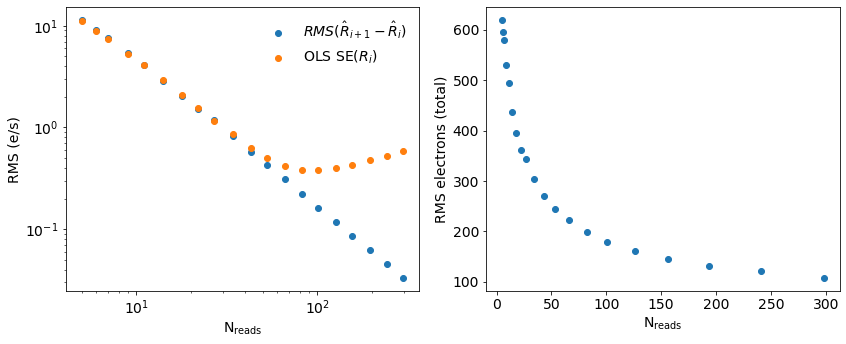

In [418]:
fig, axarr = plt.subplots(1,2,figsize=(12,5))
ax = axarr[0]
ax.scatter ( xs, risingstats[0], label=r'$RMS(\hat R_{i+1} - \hat R_i)$' )
#ax.plot ( xs, risingstats[1]*np.sqrt(2.), label=r'$\sqrt{2}RMS(R_i - \hat R_{\rm true})$', color='k' )
ax.scatter ( xs, risingstats[2], label=r'OLS SE($R_i$)' )
ax.legend (frameon=False)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'N$\rm_{reads}$')
ax.set_ylabel('RMS (e/s)')

ax = axarr[1]
ax.scatter ( xs, risingstats[0]*rampA.header()['W_FRMTIM']*xs )

#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'N$\rm_{reads}$')
ax.set_ylabel('RMS electrons (total)')

plt.tight_layout ()
plt.savefig('../figures/ratebump.png')

In [145]:
_,rhatA,rhatA_se = ramputils.utr_expectedflux ( cubeA )
bestest_dc = statutils.sigclip_insitu(rhatA[0]) * makefigures_noise.gain / rampA.header()['W_FRMTIM']

In [148]:
Nreads, cubestats = ramputils.compute_uncertainties ( cubeA, cubeB, 
                                              expected=bestest_dc,
                                              gain=makefigures_noise.gain, 
                                              exptime=rampA.header()['W_FRMTIM'])

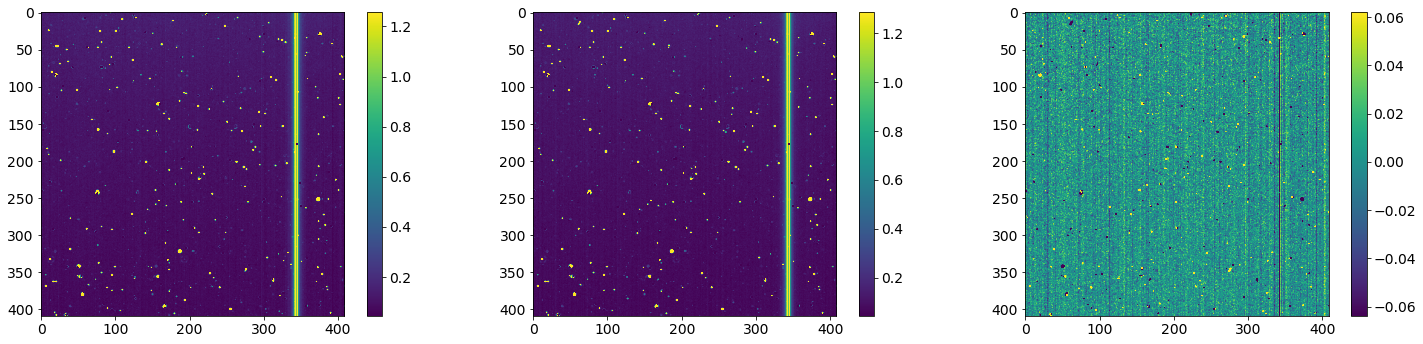

In [400]:
_,rhatA,_ = ramputils.utr_expectedflux ( cubeA )
_,rhatB,_ = ramputils.utr_expectedflux ( cubeB )

fig, axarr = plt.subplots(1,3,figsize=(21,5))
plot.scaled_imshow(rhatA[0], ax=axarr[0])
plot.scaled_imshow(rhatB[0], ax=axarr[1])
plot.scaled_imshow(rhatA[0]-rhatB[0], ax=axarr[2])
plt.tight_layout ()
plt.savefig('../figures/ratediff_corr.png')

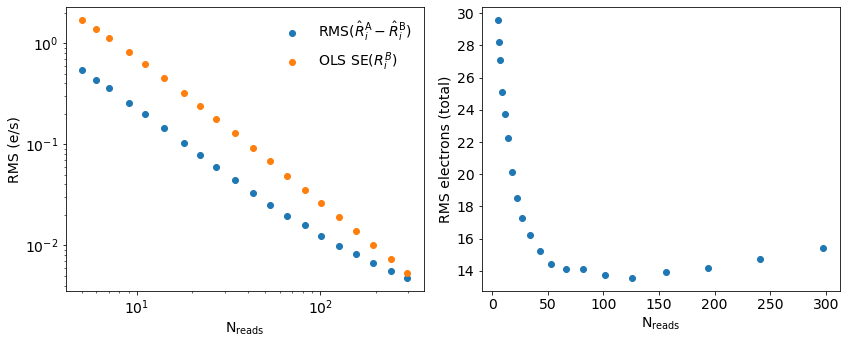

In [401]:
fig, axarr = plt.subplots(1,2,figsize=(12,5))
ax = axarr[0]
ax.scatter ( Nreads, cubestats[0], label=r'RMS$(\hat R^{\rm A}_{i} - \hat R^{\rm B}_i)$' )
#ax.plot ( Nreads, cubestats[1]*np.sqrt(2.), label=r'$\sqrt{2}RMS(R^B_i - \hat R_{\rm true})$', color='k' )
ax.scatter ( Nreads, cubestats[2], label=r'OLS SE($R^B_i$)' )
ax.legend (frameon=False)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'N$\rm_{reads}$')
ax.set_ylabel('RMS (e/s)')

ax = axarr[1]
ax.scatter ( Nreads, cubestats[0]*rampA.header()['W_FRMTIM']*Nreads )
#ax.scatter ( Nreads, cubestats[2]*rampA.header()['W_FRMTIM']*Nreads )
#ax.set_Nreadscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'N$\rm_{reads}$')
ax.set_ylabel('RMS electrons (total)')

plt.tight_layout ()
plt.savefig('../figures/ratestats_corr.png')

In [228]:
Nreads, datastats = ramputils.compute_uncertainties ( dataA, dataB, 
                                                      gain=makefigures_noise.gain, 
                                                      exptime=rampA.header()['W_FRMTIM'])

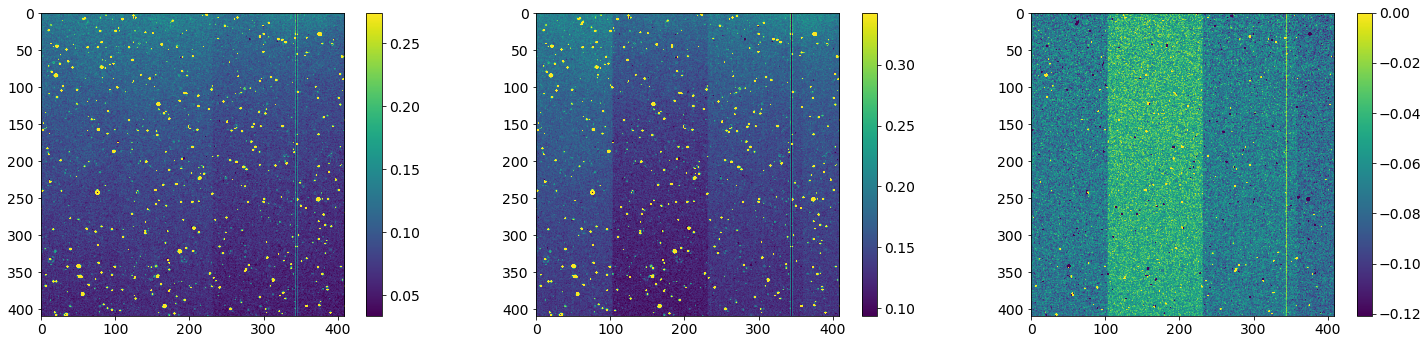

In [402]:
_,rhatA,_ = ramputils.utr_expectedflux ( dataA )
_,rhatB,_ = ramputils.utr_expectedflux ( dataB )

fig, axarr = plt.subplots(1,3,figsize=(21,5))
plot.scaled_imshow(rhatA[0], ax=axarr[0])
plot.scaled_imshow(rhatB[0], ax=axarr[1])
plot.scaled_imshow(rhatA[0]-rhatB[0], ax=axarr[2])
plt.tight_layout ()
plt.savefig('../figures/ratediff_data.png')

In [243]:
from matplotlib import lines

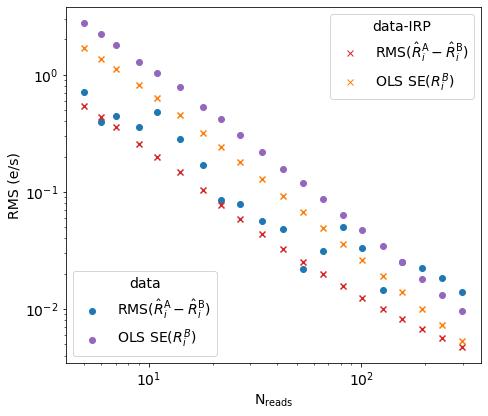

In [403]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
#ax = axarr[0]
ax.scatter ( Nreads, datastats[0], label=r'''RMS$(\hat R^{\rm A}_{i} - \hat R^{\rm B}_i)$''',
           color='tab:blue')
ax.scatter ( Nreads, datastats[2], label=r'''OLS SE($R^B_i$)''',
           color='tab:purple')

ax.scatter ( Nreads, cubestats[0], marker='x', color='tab:red' )
ax.scatter ( Nreads, cubestats[2], marker='x', color='tab:orange')
legend1= ax.legend ( loc='lower left', title='data' )

# \\ second legend
custom_lines = [lines.Line2D([0], [0], color='w', markeredgecolor='tab:red',
                             marker='x', label=r'RMS$(\hat R^{\rm A}_{i} - \hat R^{\rm B}_i)$'),
                lines.Line2D([0], [0], color='w', markeredgecolor='tab:orange',
                             marker='x', label=r'OLS SE($R^B_i$)')
                             ]
legend2 = ax.legend(handles=custom_lines, loc='upper right', title='data-IRP')
ax.add_artist(legend1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'N$\rm_{reads}$')
ax.set_ylabel('RMS (e/s)')

plt.tight_layout()
plt.savefig('../figures/ratestats_data.png')

In [223]:
findices = np.arange(300).reshape(300,1,1,)
additional_rate = 30.
additional_noise = 1e5
noise = lambda : np.random.normal(0., additional_noise, [findices.size, cubeA.shape[1], cubeA.shape[2]])
boosted_cubeA = cubeA + findices*additional_rate + noise ()
boosted_cubeB = cubeB + findices*additional_rate + noise ()

In [224]:
_,rhatA,rhatA_se = ramputils.utr_expectedflux ( cubeA )
bestest_dc = rhatA[0]

In [225]:
Nreads, boosted_cubestats = ramputils.compute_uncertainties ( boosted_cubeA, boosted_cubeB, 
                                              expected=additional_rate )

Caution! Gain=1
Caution! Exptime=1 sec


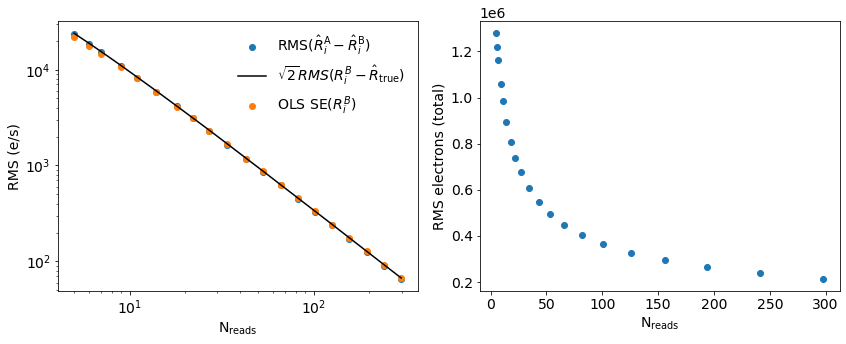

In [226]:
fig, axarr = plt.subplots(1,2,figsize=(12,5))
ax = axarr[0]
ax.scatter ( Nreads, boosted_cubestats[0], label=r'RMS$(\hat R^{\rm A}_{i} - \hat R^{\rm B}_i)$' )
ax.plot ( Nreads, boosted_cubestats[1]*np.sqrt(2.), label=r'$\sqrt{2}RMS(R^B_i - \hat R_{\rm true})$', color='k' )
ax.scatter ( Nreads, boosted_cubestats[2], label=r'OLS SE($R^B_i$)' )
ax.legend (frameon=False)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'N$\rm_{reads}$')
ax.set_ylabel('RMS (e/s)')

ax = axarr[1]
ax.scatter ( Nreads, boosted_cubestats[0]*rampA.header()['W_FRMTIM']*Nreads )

#ax.set_Nreadscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'N$\rm_{reads}$')
ax.set_ylabel('RMS electrons (total)')

plt.tight_layout ()